# Exercise 6

In [1]:
# Basic
import random
from functools import reduce

# Data
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split

# DL
from tensorflow.keras.datasets import mnist

c:\Users\OmriG\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

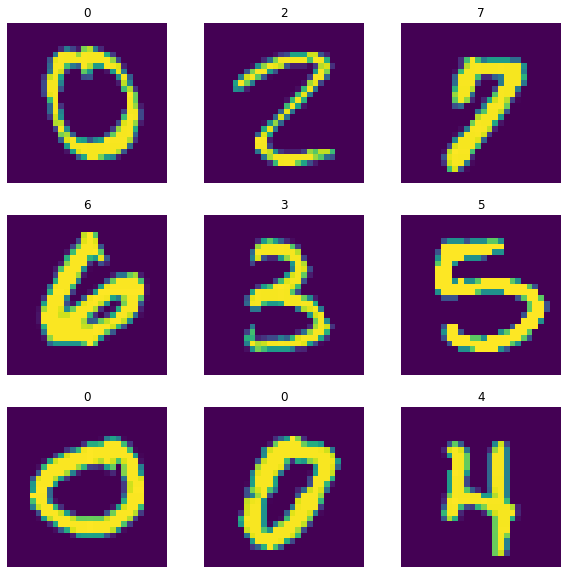

In [3]:
GRID_SIZE = 3

pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, GRID_SIZE**2)

fig, ax = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(10, 10))
for i, (img, digit) in enumerate(samples):
    row, col = i//GRID_SIZE, i%GRID_SIZE
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2. Model

In [4]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, batch_norm=False):
        self.activation_fn = lambda x: np.maximum(x, 0) # TODO add more options
        self.batch_norm = batch_norm

        layer_sizes = [input_size, *hidden_sizes, output_size]
        self.weights = [
            np.random.standard_normal((size_from, size_to))
            for size_from, size_to in zip(layer_sizes[:-1], layer_sizes[1:])
        ]

    def __batch_norm(batch):
        return batch

    def fit(self, X, y, lr=1e-3, num_epochs=10):
        # TODO implement
        return self

    def predict_proba(self, X):
        return softmax(reduce(lambda x, w: self.activation_fn(x @ w), [X, *self.weights]))

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)

## 3. Training

In [6]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

nn_clf = NeuralNetwork(input_size=X_train_flat.shape[1], 
                       hidden_sizes=[256, 256],
                       output_size=np.unique(y_train).size).fit(X_train_flat, y_train)

100 * nn_clf.score(X_val_flat, y_val)

C:\Users\OmriG\AppData\Local\Temp\ipykernel_11164\359680728.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
C:\Users\OmriG\AppData\Local\Temp\ipykernel_11164\359680728.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


9.458333333333334

## 4. Evaluation

In [7]:
X_test_flat = X_test.reshape(X_test.shape[0], -1)

100 * nn_clf.score(X_test_flat, y_test)

C:\Users\OmriG\AppData\Local\Temp\ipykernel_11164\359680728.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
C:\Users\OmriG\AppData\Local\Temp\ipykernel_11164\359680728.py:2: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


9.85

## 5. Experiments

In [ ]:
# TODO experiments